In [151]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string

from sklearn.metrics.pairwise import cosine_distances, cosine_similarity

%matplotlib inline
%config InlineBackend.feature_format = 'retina'

### Loading in the DataFrame that I made which includes data about all the books. The text of the books has been removed now that I have data about the words, syllables, reading levels, and subjects extracted. I also make the subjects easier to parse through and load up the tfidf vectorized books dataframe and the count vectorized books dataframe.

In [2]:
meta_stats = pd.read_csv('meta_stats_all_notext', encoding = 'utf8', index_col = 'Unnamed: 0')

In [3]:
meta_stats['subjects2'] = meta_stats['subjects2'].map(lambda x: x.replace('[', '').replace(']','').split(','))

def clean_sub2(sublist):
    subs = []
    for s in sublist:
        subs.append(string.strip(s))
    return subs

meta_stats['subjects2'] = meta_stats['subjects2'].map(clean_sub2)

In [4]:
def unique_words(subjects):
    s = []
    for x in subjects:
        s.extend(x.split(' '))
    return np.unique(s)

meta_stats['subjects3'] = meta_stats['subjects2'].map(unique_words)

In [5]:
tvec_all = pd.read_csv('tvec_all', encoding = 'utf8', index_col = 'Unnamed: 0')

In [6]:
cvec_all = pd.read_csv('cvec_all', encoding = 'utf8', index_col = 'Unnamed: 0')

### The user selects a book and the dataframe is narrowed down to only include the books within a range of appropriate reading levels of that book.

In [124]:
chosen_title = "The War of the Worlds"

In [125]:
try:
    chosen_book = meta_stats[meta_stats['title'] == chosen_title]
    chosen_id = chosen_book['book_id'].values[0]
    print (chosen_id)
    
except:
    print ("This book is not in the dataset. Choose another book.")

36


#### Here is the range of reading levels that will be allowed:

In [126]:
flesch_k_max = chosen_book['flesch_kincaid_grade'].values[0] + 0.25
flesch_k_min = chosen_book['flesch_kincaid_grade'].values[0] - 1.00
flesch_k_min, flesch_k_max

(8.9575154692199987, 10.207515469219999)

In [127]:
flesch_k_subset = meta_stats[meta_stats['flesch_kincaid_grade'].between(flesch_k_min, flesch_k_max)].reset_index(drop = True)
flesch_k_subset.shape

(2881, 27)

In [128]:
flesch_k_subset.head(2)

,book_id,title,title_ascii,author,authoryearofbirth,authoryearofdeath,downloads,subjects,subjects2,LCC,...,sentence_count,syllable_count,avg_sentence_length,avg_syllables_per_word,dialogue,dialogue_per_sentence,flesch_reading_ease,flesch_kincaid_grade,formats,subjects3
0,32,Herland,Herland,"Gilman, Charlotte Perkins",1860.0,1935.0,309,"{Women -- Fiction, Utopian fiction, Utopias --...","[black humor, fiction, utopian fiction, utopia...",{PS},...,3179,81207,16.402957,1.557331,1071.0,0.336898,58.435837,9.183653,{u'text/plain; charset=utf-8': u'http://www.gu...,"[black, fiction, humor, utopian, utopias, women]"
1,35,The Time Machine,TheTimeMachine,"Wells, H. G. (Herbert George)",1866.0,1946.0,4458,"{Science fiction, Dystopias -- Fiction, Time t...","[dystopias, fiction, science fiction, time tra...",{PR},...,1902,49840,16.981073,1.543130,20.0,0.010515,59.050447,9.241548,{u'text/html': u'http://www.gutenberg.org/eboo...,"[dystopias, fiction, science, time, travel]"


In [129]:
subset_bids = flesch_k_subset[['book_id']]
subset_bids.shape

(2881, 1)

## Creating a column to recommend books based upon TFIDF

### Loading in the tfidf vectorized books to use for one metric of recommendation.

In [130]:
tvec_all.head(5)

,00,000,10,11,12,12mo,13,14,15,16,...,youa,young,younger,youngest,youngster,youth,youthful,youths,zeal,zip
0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0
1,0.0,0.0,0.003734,0.004122,0.004122,0.0,0.004321,0.008664,0.004067,0.004321,...,0.0,0.0,0.001161,0.001695,0.0,0.002144,0.000000,0.0,0.000000,0.0
2,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.012668,0.015863,0.0,0.008360,0.000000,0.0,0.005754,0.0
3,0.0,0.0,0.001540,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.005742,0.002796,0.0,0.008841,0.001341,0.0,0.000000,0.0
4,0.0,0.0,0.005085,0.005614,0.005614,0.0,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.006321,0.013852,0.0,0.011680,0.000000,0.0,0.000000,0.0


In [131]:
tvec_subset = subset_bids.merge(tvec_all, how = 'inner', on = 'book_id').reset_index(drop = True)

### I'm using cosine distance to determine how different the books are from each other.

In [132]:
book_ids = tvec_subset.book_id
tvec_subset = tvec_subset.drop('book_id', axis = 1)

t_subset_distances = cosine_distances(tvec_subset)
t_subset_distances_df = pd.DataFrame(t_subset_distances, columns=book_ids)
t_subset_distances_df['book_id'] = book_ids

t_subset_distances_df.head()

book_id,32,35,36,42,60,72,78,81,86,98,...,50676,50993,51557,51760,51772,51980,52703,53323,53422,book_id
0,0.000000,0.688081,0.710106,0.814520,0.760969,0.769241,0.804181,0.786171,0.686078,0.761919,...,0.728737,0.881804,0.857081,0.914333,0.800185,0.624558,0.782635,0.660791,0.838020,32
1,0.688081,0.000000,0.590635,0.839609,0.823005,0.775204,0.845560,0.825696,0.807814,0.804510,...,0.828109,0.935829,0.908016,0.960072,0.856578,0.775807,0.850237,0.744122,0.878317,35
2,0.710106,0.590635,0.000000,0.828622,0.743501,0.693737,0.826222,0.802335,0.764608,0.758564,...,0.779674,0.914303,0.865196,0.945507,0.837142,0.755826,0.830298,0.718612,0.838551,36
3,0.814520,0.839609,0.828622,0.000000,0.711203,0.865108,0.828797,0.849254,0.783856,0.531480,...,0.708822,0.943064,0.848353,0.953124,0.937148,0.810566,0.825109,0.693513,0.927890,42
4,0.760969,0.823005,0.743501,0.711203,0.000000,0.794318,0.809665,0.748296,0.623640,0.566254,...,0.572360,0.897292,0.791282,0.942961,0.891637,0.690058,0.702786,0.659157,0.879019,60


In [133]:
t_chosen_distances = t_subset_distances_df[[chosen_id, 'book_id']]
flesch_k_subset = flesch_k_subset.merge(t_chosen_distances, how = 'inner', on = 'book_id')
flesch_k_subset.rename(columns = {chosen_id : 'tfidf_distances'}, inplace = True)

In [134]:
flesch_k_subset.sort_values('tfidf_distances').head(5)

,book_id,title,title_ascii,author,authoryearofbirth,authoryearofdeath,downloads,subjects,subjects2,LCC,...,syllable_count,avg_sentence_length,avg_syllables_per_word,dialogue,dialogue_per_sentence,flesch_reading_ease,flesch_kincaid_grade,formats,subjects3,tfidf_distances
2,36,The War of the Worlds,TheWaroftheWorlds,"Wells, H. G. (Herbert George)",1866.0,1946.0,2563,"{War stories, Mars (Planet) -- Fiction, Scienc...","[fiction, imaginary wars and battles, life on ...",{PR},...,92041,19.036849,1.535860,406.0,0.128971,57.578868,9.957515,{u'application/x-mobipocket-ebook': u'http://w...,"[and, battles, fiction, imaginary, life, mars,...",0.000000
2667,42989,"The Plattner Story, and Others",ThePlattnerStoryandOthers,"Wells, H. G. (Herbert George)",1866.0,1946.0,58,"{Short stories, English, Great Britain -- Soci...","[fiction, great britain, science fiction, shor...",{PR},...,119624,16.691236,1.535649,1150.5,0.246518,59.977474,9.040243,{u'image/jpeg': u'http://www.gutenberg.org/cac...,"[and, britain, customs, english, fiction, grea...",0.536455
93,780,The War in the Air,TheWarintheAir,"Wells, H. G. (Herbert George)",1866.0,1946.0,114,"{Science fiction, Air warfare -- Fiction, War ...","[air warfare, fiction, science fiction, war st...",{PR},...,152274,17.148711,1.568283,1289.0,0.227658,56.752322,9.603736,{u'text/html; charset=utf-8': u'http://www.gut...,"[air, fiction, science, stories, war, warfare]",0.556811
352,3797,In the Days of the Comet,IntheDaysoftheComet,"Wells, H. G. (Herbert George)",1866.0,1946.0,61,"{Political fiction, Science fiction, Utopias -...","[collisions with earth, comets, fiction, polit...",{PR},...,124765,18.970630,1.545288,935.0,0.219690,56.848454,10.042943,{u'text/html': u'http://www.gutenberg.org/eboo...,"[collisions, comets, earth, fiction, political...",0.562453
111,1138,The Research Magnificent,TheResearchMagnificent,"Wells, H. G. (Herbert George)",1866.0,1946.0,17,{Conduct of life -- Fiction},"[conduct of life, fiction]",{PR},...,175231,15.875286,1.580466,1646.0,0.235682,57.014166,9.250860,{u'text/html; charset=utf-8': u'http://www.gut...,"[conduct, fiction, life, of]",0.568944


## Recommending by Count Vectorized Book Text Similarity

In [135]:
cvec_subset = subset_bids.merge(cvec_all, how = 'inner', on = 'book_id').reset_index(drop = True)

In [136]:
book_ids = cvec_subset.book_id
cvec_subset = cvec_subset.drop('book_id', axis = 1)

c_subset_distances = cosine_distances(cvec_subset)
c_subset_distances_df = pd.DataFrame(c_subset_distances, columns=book_ids)
c_subset_distances_df['book_id'] = book_ids

c_subset_distances_df.head()

book_id,32,35,36,42,60,72,78,81,86,98,...,50676,50993,51557,51760,51772,51980,52703,53323,53422,book_id
0,0.000000,0.881874,0.919953,0.943129,0.957624,0.915184,0.938949,0.934705,0.899651,0.936972,...,0.920256,0.986540,0.970882,0.988436,0.973203,0.895458,0.946838,0.860765,0.973267,32
1,0.881874,0.000000,0.809123,0.893301,0.969167,0.919506,0.961710,0.954351,0.932776,0.945207,...,0.942537,0.988992,0.973695,0.994677,0.982501,0.927755,0.966643,0.915527,0.978922,35
2,0.919953,0.809123,0.000000,0.945888,0.953850,0.817617,0.965640,0.966730,0.927496,0.943393,...,0.948620,0.989259,0.974611,0.991991,0.976231,0.930285,0.966969,0.887809,0.956583,36
3,0.943129,0.893301,0.945888,0.000000,0.959814,0.960321,0.953651,0.956883,0.955564,0.943913,...,0.928124,0.995580,0.970479,0.988971,0.988920,0.935943,0.959192,0.936873,0.988928,42
4,0.957624,0.969167,0.953850,0.959814,0.000000,0.951262,0.973782,0.896175,0.949128,0.707510,...,0.852858,0.937558,0.972402,0.995388,0.983898,0.915095,0.844441,0.957721,0.981123,60


In [137]:
c_chosen_distances = c_subset_distances_df[[chosen_id, 'book_id']]
flesch_k_subset = flesch_k_subset.merge(c_chosen_distances, how = 'inner', on = 'book_id')
flesch_k_subset.rename(columns = {chosen_id : 'cvec_distances'}, inplace = True)

flesch_k_subset.sort_values('cvec_distances').head(5)



,book_id,title,title_ascii,author,authoryearofbirth,authoryearofdeath,downloads,subjects,subjects2,LCC,...,avg_sentence_length,avg_syllables_per_word,dialogue,dialogue_per_sentence,flesch_reading_ease,flesch_kincaid_grade,formats,subjects3,tfidf_distances,cvec_distances
2,36,The War of the Worlds,TheWaroftheWorlds,"Wells, H. G. (Herbert George)",1866.0,1946.0,2563,"{War stories, Mars (Planet) -- Fiction, Scienc...","[fiction, imaginary wars and battles, life on ...",{PR},...,19.036849,1.535860,406.0,0.128971,57.578868,9.957515,{u'application/x-mobipocket-ebook': u'http://w...,"[and, battles, fiction, imaginary, life, mars,...",0.000000,0.000000
1631,25295,Pharaoh's Broker: Being the Very Remarkable Ex...,PharaohsBrokerBeingtheVeryRemarkableExperience...,"Douglass, Ellsworth",NaN,NaN,34,{Science fiction},[science fiction],{PR},...,19.560573,1.509670,932.0,0.256608,59.262931,9.852730,{u'application/rdf+xml': u'http://www.gutenber...,"[fiction, science]",0.695917,0.657118
966,13716,A Trip to Venus: A Novel,ATriptoVenusANovel,"Munro, John",1849.0,1930.0,51,"{Venus (Planet) -- Fiction, Science fiction}","[fiction, science fiction, venus planet]",{PR},...,19.395474,1.543667,905.5,0.347334,56.554329,10.189510,{u'text/plain; charset=utf-8': u'http://www.gu...,"[fiction, planet, science, venus]",0.702562,0.720692
1908,31282,Mars Confidential,MarsConfidential,"Browne, Howard",1907.0,1999.0,18,"{Mars (Planet) -- Fiction, Mafia -- Fiction, S...","[fiction, mafia, mars planet, science fiction,...",{PS},...,15.963483,1.570649,38.0,0.106742,57.755133,9.169420,{u'image/jpeg': u'http://www.gutenberg.org/cac...,"[fiction, mafia, mars, planet, science, short,...",0.732224,0.721248
2752,44534,A Trip to Mars,ATriptoMars,"Aubrey, Frank",1847.0,1927.0,12,"{Science fiction, Mars (Planet) -- Fiction}","[fiction, mars planet, science fiction]",{PR},...,18.000240,1.528793,32.0,0.007694,59.228902,9.469846,{u'application/rdf+xml': u'http://www.gutenber...,"[fiction, mars, planet, science]",0.781816,0.739865


## Recommending Books By Subject Similarity

In [138]:
def jaccard(list1, list2):
    
    a = set(list1)
    b = set(list2)

    return round(len(a.intersection(b)) / float(len(a.union(b))), 5)

In [139]:
subject_jaccards = []

for book in range(flesch_k_subset.shape[0]):
    subject_jaccards.append(jaccard(flesch_k_subset.ix[book,'subjects3'].tolist(), 
                                                chosen_book['subjects3'].values[0].tolist()))
    
flesch_k_subset['subject_jaccard'] = subject_jaccards
flesch_k_subset.sort_values('subject_jaccard', ascending = False).head(5)

,book_id,title,title_ascii,author,authoryearofbirth,authoryearofdeath,downloads,subjects,subjects2,LCC,...,avg_syllables_per_word,dialogue,dialogue_per_sentence,flesch_reading_ease,flesch_kincaid_grade,formats,subjects3,tfidf_distances,cvec_distances,subject_jaccard
2,36,The War of the Worlds,TheWaroftheWorlds,"Wells, H. G. (Herbert George)",1866.0,1946.0,2563,"{War stories, Mars (Planet) -- Fiction, Scienc...","[fiction, imaginary wars and battles, life on ...",{PR},...,1.535860,406.0,0.128971,57.578868,9.957515,{u'application/x-mobipocket-ebook': u'http://w...,"[and, battles, fiction, imaginary, life, mars,...",0.000000,0.000000,1.00000
1721,27434,Doctor Jones' Picnic,DoctorJonesPicnic,"Chapman, S. E. (Samuel E.)",NaN,NaN,5,"{Science fiction, Imaginary wars and battles -...","[fiction, imaginary wars and battles, science ...",{PS},...,1.539635,1138.0,0.301857,59.820886,9.017870,{u'text/plain; charset=us-ascii': u'http://www...,"[and, battles, fiction, imaginary, science, wars]",0.870465,0.974012,0.35294
1969,32284,The Hitch Hikers,TheHitchHikers,"McCain, Vernon L.",NaN,NaN,15,"{Human-alien encounters -- Fiction, Martians -...","[fiction, human-alien encounters, mars planet,...",{PS},...,1.676491,87.5,0.301724,49.922356,9.987457,{u'image/jpeg': u'http://www.gutenberg.org/cac...,"[encounters, fiction, human-alien, mars, marti...",0.831775,0.891843,0.30000
5,72,"Thuvia, Maid of Mars",ThuviaMaidofMars,"Burroughs, Edgar Rice",1875.0,1950.0,373,"{Science fiction, Martians -- Fiction, Mars (P...","[fiction, mars planet, martians, science fiction]",{PS},...,1.514880,631.5,0.234671,60.907046,9.113121,{u'text/plain; charset=us-ascii': u'http://www...,"[fiction, mars, martians, planet, science]",0.693737,0.817617,0.29412
93,780,The War in the Air,TheWarintheAir,"Wells, H. G. (Herbert George)",1866.0,1946.0,114,"{Science fiction, Air warfare -- Fiction, War ...","[air warfare, fiction, science fiction, war st...",{PR},...,1.568283,1289.0,0.227658,56.752322,9.603736,{u'text/html; charset=utf-8': u'http://www.gut...,"[air, fiction, science, stories, war, warfare]",0.556811,0.776935,0.27778


In [140]:
mask_title = flesch_k_subset['title'] != chosen_title

s_recs = flesch_k_subset[mask_title].sort_values('subject_jaccard', ascending = False).head(10).title.values + ' by ' + flesch_k_subset[mask_title].sort_values('subject_jaccard', ascending = False).head(10).author.values 
t_recs = flesch_k_subset[mask_title].sort_values('tfidf_distances').head(10).title.values + ' by ' + flesch_k_subset[mask_title].sort_values('tfidf_distances').head(10).author.values 
c_recs = flesch_k_subset[mask_title].sort_values('cvec_distances').head(10).title.values + ' by ' + flesch_k_subset[mask_title].sort_values('cvec_distances').head(10).author.values 

recommended_books = pd.DataFrame({
        'Subject Based Recommendation' : s_recs,
        'tf-idf Based Recommendation' : t_recs,
        'Count Vectorizer Based Recommendation' : c_recs
    })

In [141]:
recommended_books.head(12)

,Count Vectorizer Based Recommendation,Subject Based Recommendation,tf-idf Based Recommendation
0,Pharaoh's Broker: Being the Very Remarkable Ex...,"Doctor Jones' Picnic by Chapman, S. E. (Samuel...","The Plattner Story, and Others by Wells, H. G...."
1,"A Trip to Venus: A Novel by Munro, John","The Hitch Hikers by McCain, Vernon L.","The War in the Air by Wells, H. G. (Herbert Ge..."
2,"Mars Confidential by Browne, Howard","Thuvia, Maid of Mars by Burroughs, Edgar Rice","In the Days of the Comet by Wells, H. G. (Herb..."
3,"A Trip to Mars by Aubrey, Frank","The War in the Air by Wells, H. G. (Herbert Ge...","The Research Magnificent by Wells, H. G. (Herb..."
4,"Cinq Mars — Volume 5 by Vigny, Alfred de","Keep Out by Brown, Fredric","The Time Machine by Wells, H. G. (Herbert George)"
5,"Keep Out by Brown, Fredric",The Air Patrol: A Story of the North-west Fron...,The Laird's Luck and Other Fireside Tales by Q...
6,"Invaders from the Infinite by Campbell, John W...","Mars Confidential by Browne, Howard","What Necessity Knows by Dougall, L. (Lily)"
7,"The War in the Air by Wells, H. G. (Herbert Ge...","A Journey to the Centre of the Earth by Verne,...","The Ball and the Cross by Chesterton, G. K. (G..."
8,"Tono-Bungay by Wells, H. G. (Herbert George)","A Trip to Mars by Aubrey, Frank","Tono-Bungay by Wells, H. G. (Herbert George)"
9,"The Black Star Passes by Campbell, John W., Jr...","The Chessmen of Mars by Burroughs, Edgar Rice","Taras Bulba, and Other Tales by Gogol, Nikolai..."


In [146]:
top_t = flesch_k_subset.sort_values('tfidf_distances').head(6).reset_index(drop = True)
top_c = flesch_k_subset.sort_values('cvec_distances').head(6).reset_index(drop = True)
top_s = flesch_k_subset.sort_values('subject_jaccard', ascending = False).head(6).reset_index(drop = True)

In [147]:
for t, a in zip(top_c.title, top_c.author):
    print t,' - by - ', a

The War of the Worlds  - by -  Wells, H. G. (Herbert George)
Pharaoh's Broker: Being the Very Remarkable Experiences in Another World of Isidor Werner  - by -  Douglass, Ellsworth
A Trip to Venus: A Novel  - by -  Munro, John
Mars Confidential  - by -  Browne, Howard
A Trip to Mars  - by -  Aubrey, Frank
Cinq Mars — Volume 5  - by -  Vigny, Alfred de


In [148]:
for t, a in zip(top_t.title, top_t.author):
    print t,' - by - ', a

The War of the Worlds  - by -  Wells, H. G. (Herbert George)
The Plattner Story, and Others  - by -  Wells, H. G. (Herbert George)
The War in the Air  - by -  Wells, H. G. (Herbert George)
In the Days of the Comet  - by -  Wells, H. G. (Herbert George)
The Research Magnificent  - by -  Wells, H. G. (Herbert George)
The Time Machine  - by -  Wells, H. G. (Herbert George)


In [150]:
for t, a in zip(top_s.title, top_s.author):
    print t,' - by - ', a

The War of the Worlds  - by -  Wells, H. G. (Herbert George)
Doctor Jones' Picnic  - by -  Chapman, S. E. (Samuel E.)
The Hitch Hikers  - by -  McCain, Vernon L.
Thuvia, Maid of Mars  - by -  Burroughs, Edgar Rice
The War in the Air  - by -  Wells, H. G. (Herbert George)
Keep Out  - by -  Brown, Fredric


## Some Analysis of Peter Pan

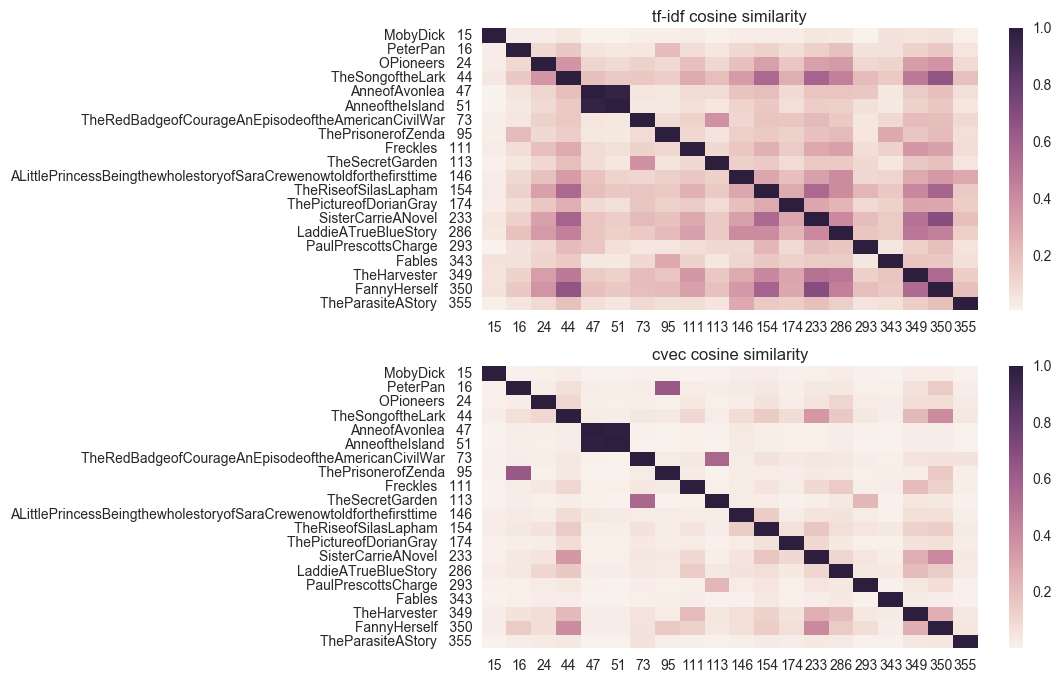

In [102]:
t_subset_similarity = cosine_similarity(tvec_subset)
c_subset_similarity = cosine_similarity(cvec_subset)
s_similarities = []
for book1 in range(20):
    book1_sims = []
    for book2 in range(20):
        book1_sims.append(jaccard(flesch_k_subset.ix[book1,'subjects3'].tolist(), 
                                                flesch_k_subset.ix[book2,'subjects3'].tolist()))
    s_similarities.append(book1_sims)


fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (8, 8))

ylabels = [t + '   ' + str(i) for t, i in zip(flesch_k_subset.title_ascii.head(20).values, flesch_k_subset.book_id.head(20).values)]
xlabels = flesch_k_subset.head(20).book_id.values

sns.heatmap(t_subset_similarity[:20,:20], xticklabels=xlabels, yticklabels=ylabels, ax = ax1)
ax1.set_title('tf-idf cosine similarity')

sns.heatmap(c_subset_similarity[:20,:20], xticklabels=xlabels, yticklabels=ylabels, ax = ax2)
ax2.set_title('cvec cosine similarity')

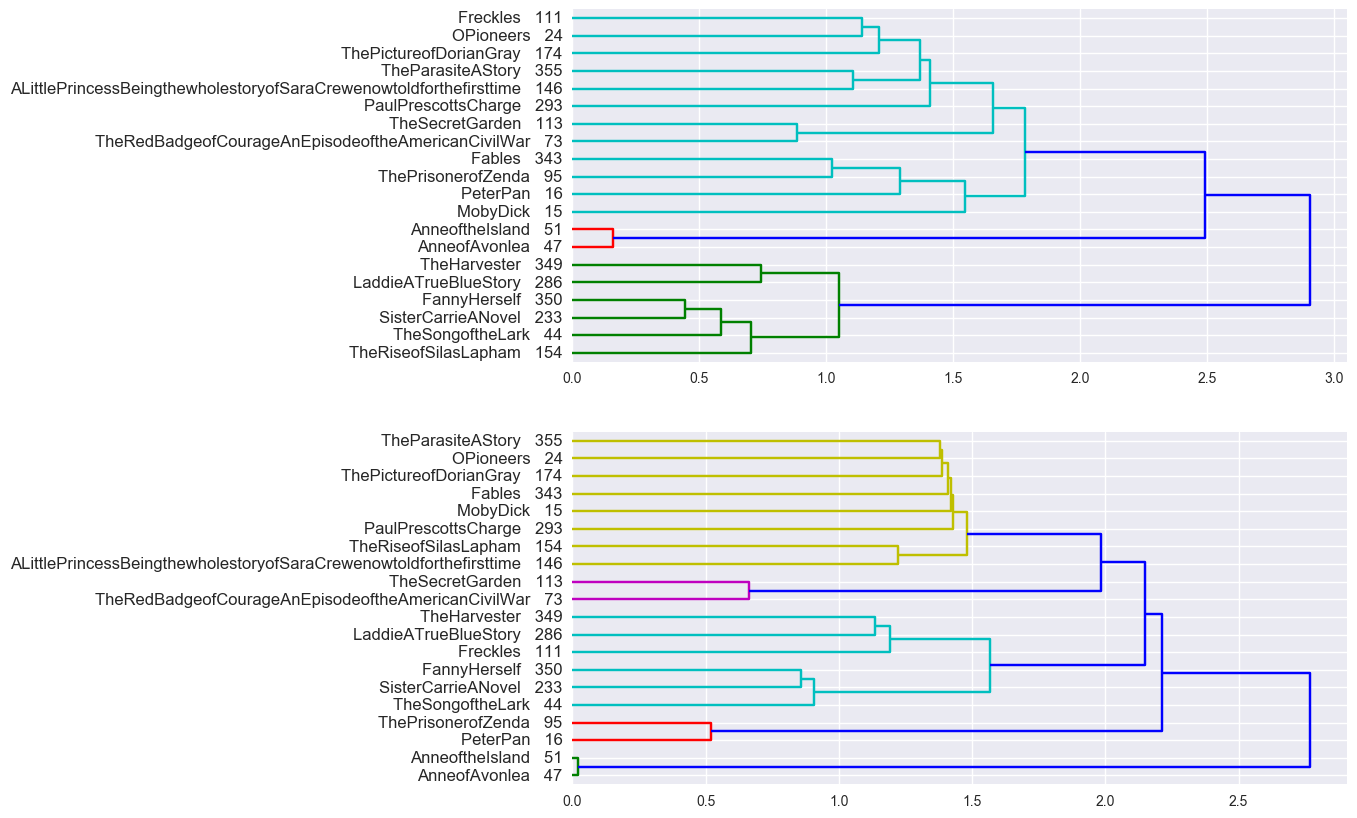

In [103]:
from scipy.cluster.hierarchy import ward, dendrogram
t_linkage_matrix = ward(t_subset_distances[:20,:20])
c_linkage_matrix = ward(c_subset_distances[:20,:20])
names = ylabels

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,10))
dendrogram(t_linkage_matrix, labels = np.array(names), orientation="right", ax=ax1)
dendrogram(c_linkage_matrix, labels = np.array(names), orientation="right", ax=ax2)

plt.show()  

In [104]:
zenda = top_c.ix[2, :]
zenda_cvec = cvec_all[cvec_all['book_id'] == zenda.book_id]
zenda_cvec

,00,000,10,100,101,103,104,105,106,109,...,youâ,zeal,zealous,zealously,zenith,zero,zest,zigzag,zip,zone
40,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,1.0


In [105]:
peter_sterling = top_t.ix[2, :]
peter_sterling_tvec = tvec_all[tvec_all['book_id'] == peter_sterling.book_id]

In [106]:
pan_tvec = tvec_all[tvec_all['book_id'] == chosen_id]
pan_cvec = cvec_all[cvec_all['book_id'] == chosen_id]

In [107]:
zenda_cvec.drop('book_id', axis = 1).T.sort_values(40, ascending = False).head(10)

,40
michael,180.0
sire,40.0
marshal,36.0
madame,34.0
ay,26.0
von,26.0
tonight,23.0
revolver,21.0
chateau,21.0
jacob,19.0


In [108]:
pan_cvec

,00,000,10,100,101,103,104,105,106,109,...,youâ,zeal,zealous,zealously,zenith,zero,zest,zigzag,zip,zone
1,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,1.0


In [109]:
pan_cvec.drop('book_id', axis = 1).T.sort_values(1, ascending = False).head(10)

,1
michael,109.0
pirates,57.0
nursery,39.0
pirate,35.0
ay,32.0
jane,28.0
fairies,24.0
curly,22.0
kennel,19.0
twins,14.0


In [110]:
peter_sterling_tvec.drop('book_id', axis = 1).T.sort_values(7061, ascending = False).head(10)

,7061
peter,0.950499
mr,0.099794
miss,0.091414
ll,0.080862
pierce,0.077477
ve,0.065874
mrs,0.046726
politics,0.042103
ward,0.041667
york,0.039734


In [112]:
pan_tvec.drop('book_id', axis = 1).T.sort_values(1, ascending = False).head(10)

,1
peter,0.781094
hook,0.299442
michael,0.280658
darling,0.190525
john,0.174765
pirates,0.145822
boys,0.112472
mrs,0.090757
nursery,0.083858
don,0.069317
